# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание проекта** 

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

**Критерии, которые важны заказчику:**
* качество предсказания;
* время обучения модели;
* время предсказания модели.

**Описание данных**

Данные находятся в файле /datasets/autos.csv. Скачать датасет. 

**Признаки**
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

**Целевой признак**
* Price — цена (евро)

## Подготовка данных

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time 
import re
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import  train_test_split
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Имеются признаки не относящиеся к ценообразованию(DateCrawled,DateCreated,NumberOfPictures,PostalCode,LastSeen), в процессе предобработки удалим их.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Признаки (VehicleType,Gearbox,FuelType,Model,Repaired)  содержат пропуски, пропусков довольно много и удалить их не получится, так же все эти признаки имеют категориальный тип следовательно добавим значение "un"(unknow), в процессе предобработки.

In [5]:
data.duplicated().sum()

4

Почистим дупликаты.

In [6]:
data = data.drop_duplicates()

In [7]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Имеются вопросы к:**
* Price - бесплатные машины?
* RegistrationYear - первую машину изобрели в 1895, на дворе 2023, судя по данным в базе 2016
* Power - минимум и максимум мощности машины удивительны
* Kilometer - пробег вполне реальный, но рассмотрим на всякий случай.

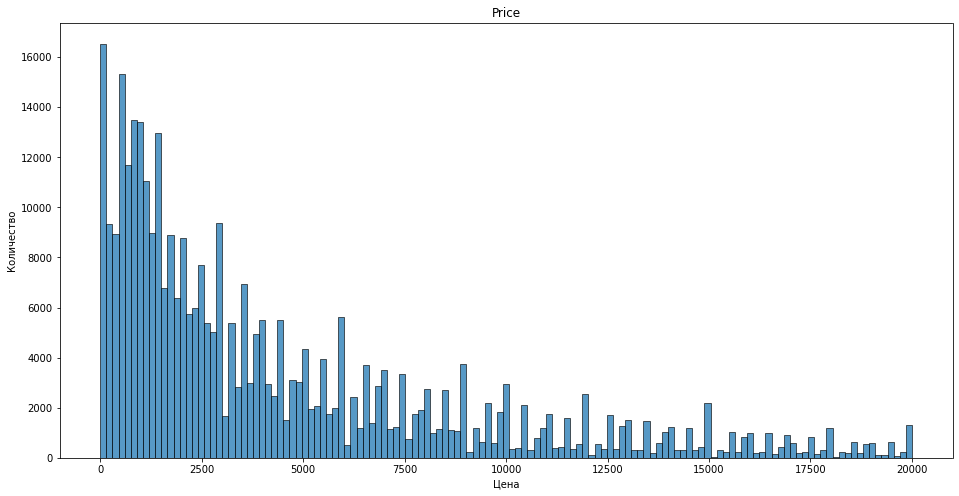

In [8]:
plt.figure(figsize=(16,8))
plt.title("Price")
plt.xlabel("Цена")
plt.ylabel("Количество")
ax = sns.histplot(data["Price"])
plt.show()

Цена в целом распределена нормально, осталось разобраться с мальникими значениями. Для этого рассмотрим 1 квартиль.


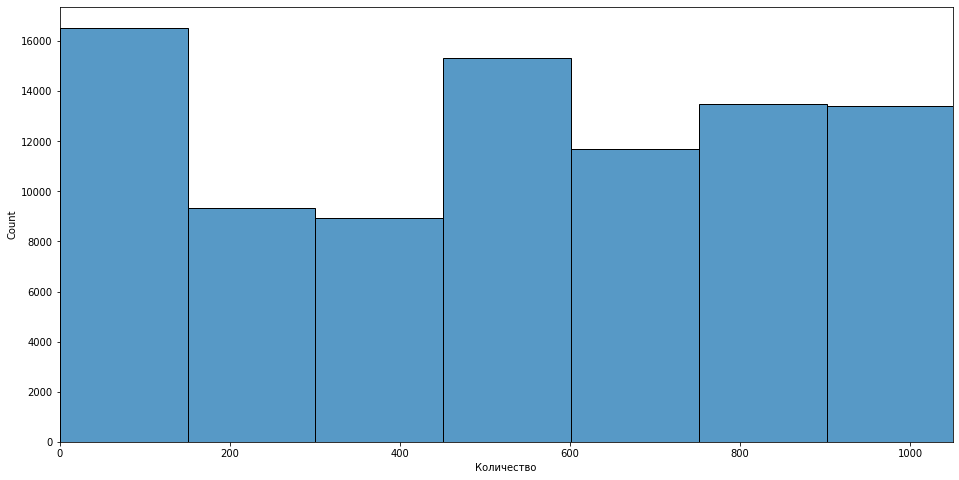

In [9]:
plt.figure(figsize=(16,8))
plt.xlabel("Количество")
plt.xlim(0,1050)
ax = sns.histplot(data["Price"])
plt.show()

Нижнюю границу возьмем 160

In [10]:
data = data.query('Price > 160')

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


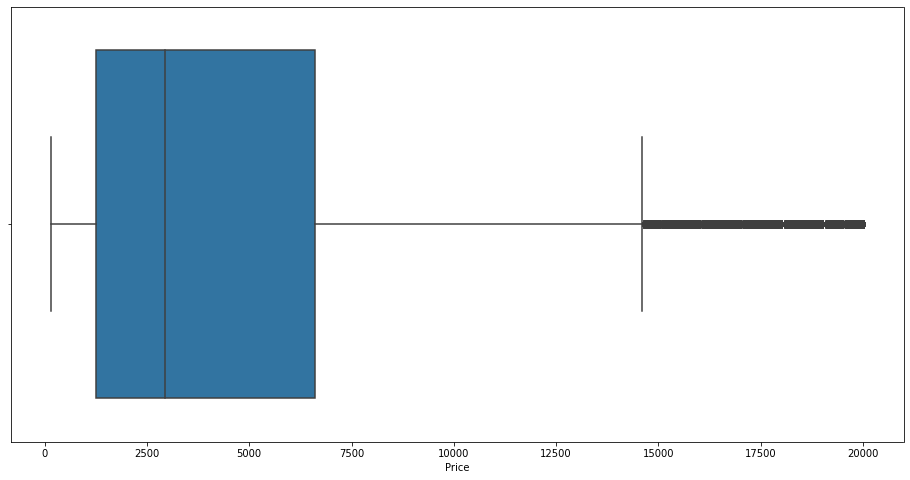

In [11]:
plt.figure(figsize=(16,8))
plt.xlabel("Количество")
ax = sns.boxplot(data["Price"])
plt.show()

Выбросы (хвост) конечно имеются, но распределены они достаточно плотно и оснований отказываться от этих данных нет

Сразу очистим данные от машин "невозможного" года регистрации.

In [12]:
data = data.query('RegistrationYear > 1900 and RegistrationYear < 2023')

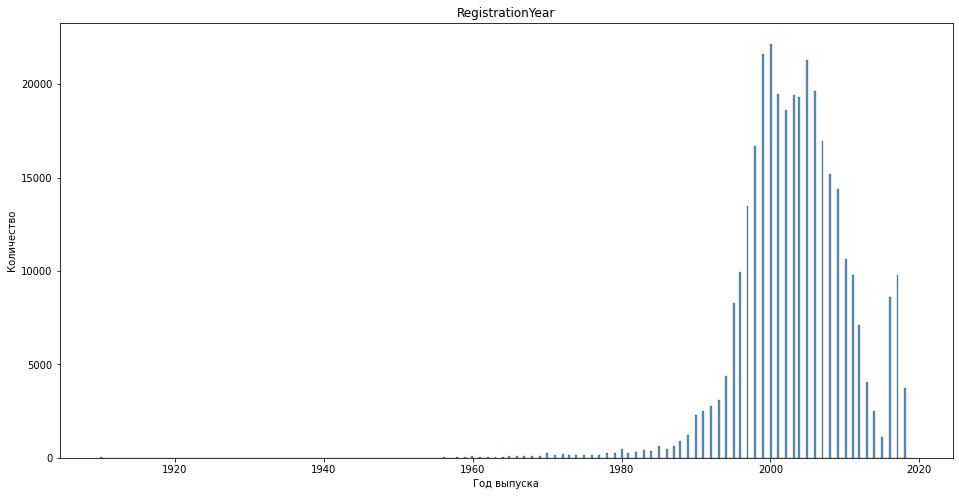

In [13]:
plt.figure(figsize=(16,8))
plt.title("RegistrationYear")
plt.xlabel("Год выпуска")
plt.ylabel("Количество")
ax = sns.histplot(data["RegistrationYear"])
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


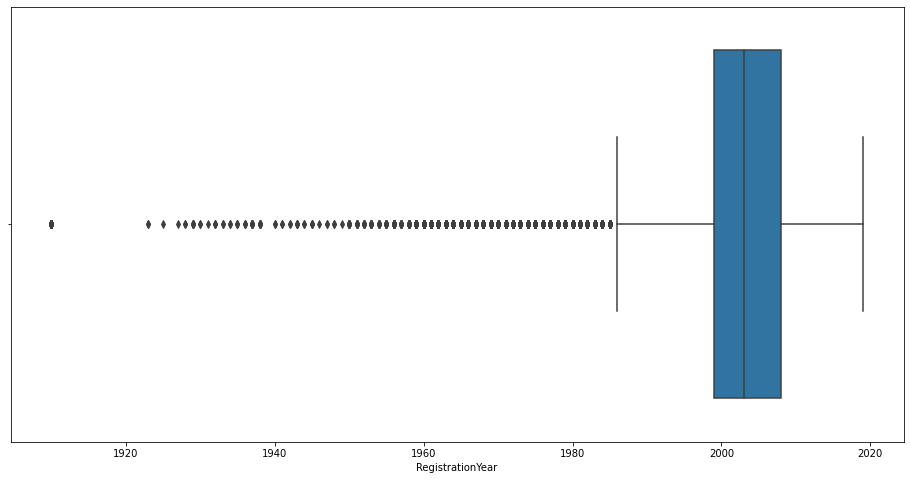

In [14]:
plt.figure(figsize=(16,8))
plt.xlabel("Количество")
ax = sns.boxplot(data["RegistrationYear"])
plt.show()

Судя по двум графикам имеет смысл исключить машины меньше 1985 года регистрации

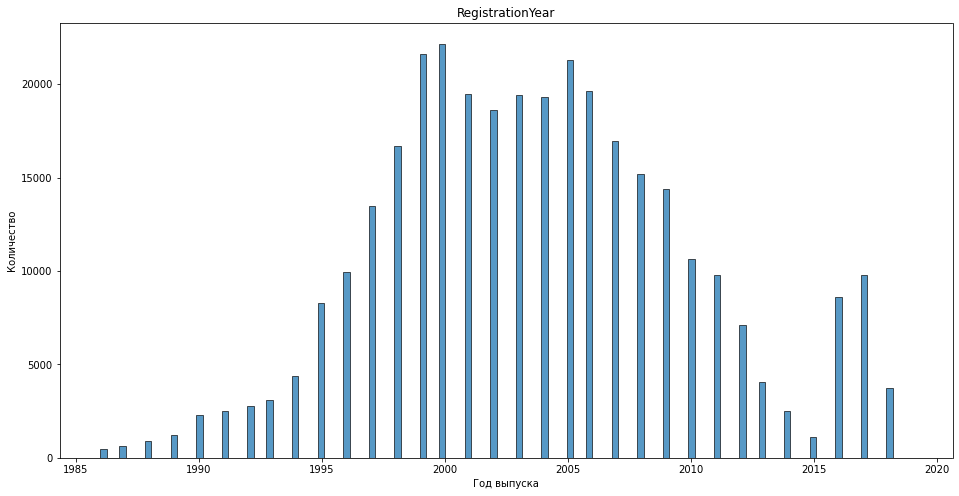

In [15]:
data = data.query('RegistrationYear > 1985 ')
plt.figure(figsize=(16,8))
plt.title("RegistrationYear")
plt.xlabel("Год выпуска")
plt.ylabel("Количество")
ax = sns.histplot(data["RegistrationYear"])
plt.show()

Красивое распределение со всплесками в 2016-18  годах, объясняется типом рынка, по этому данные оставим.

Судя по значению describe  в пробеге boxplot b histplot  не помогут, рассмотрим проблемы иначе.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


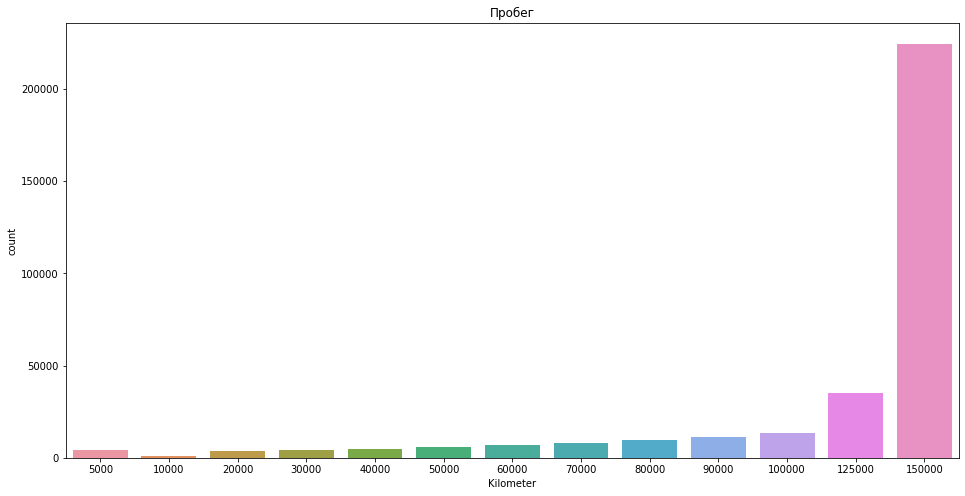

In [16]:

plt.figure(figsize=(16,8))
plt.title("Пробег")
ax = sns.countplot(data["Kilometer"])
plt.show()

Не совсем однородное но вполне нормальное распределение машин по пробегу, эти данные править смысла не вижу

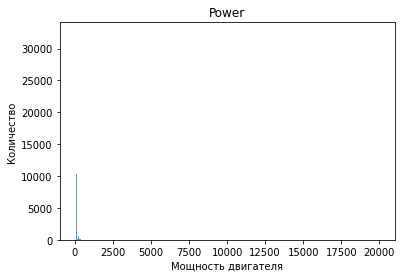

In [17]:
plt.title("Power")
plt.xlabel("Мощность двигателя")
plt.ylabel("Количество")
ax = sns.histplot(data["Power"])
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


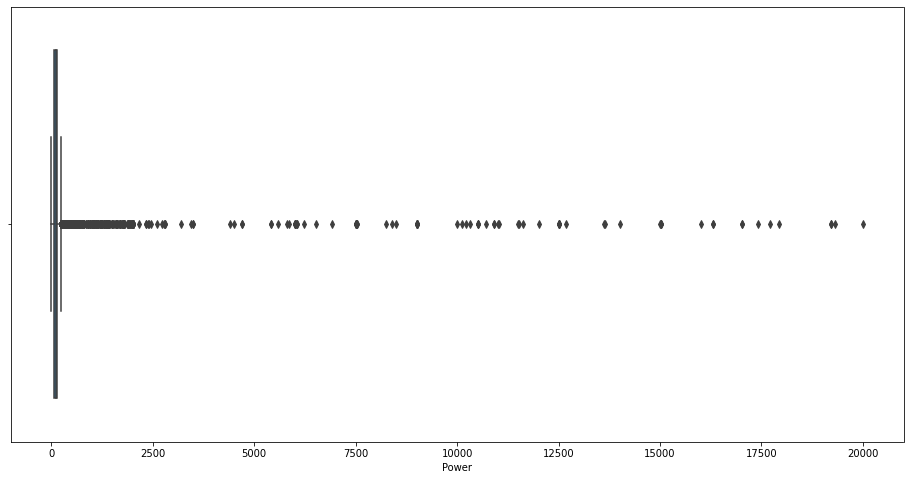

In [18]:
plt.figure(figsize=(16,8))
plt.xlabel("Количество")
ax = sns.boxplot(data["Power"])
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


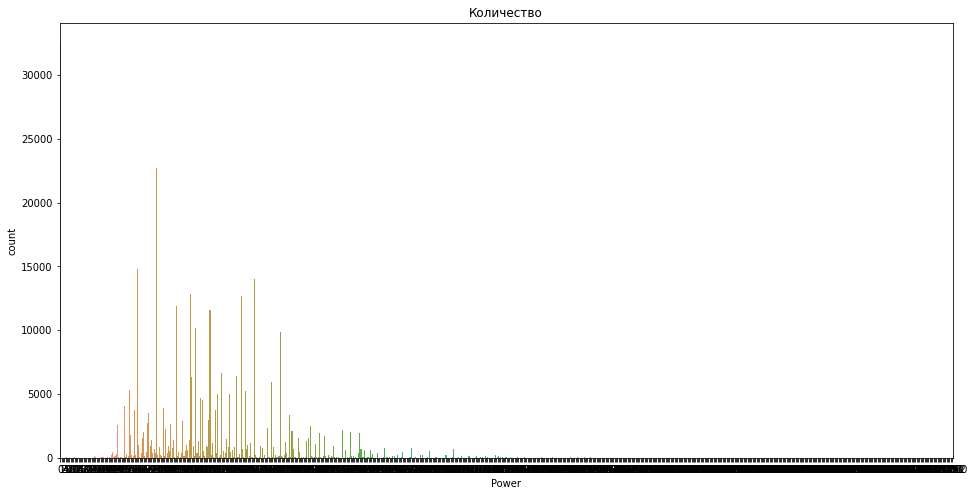

In [19]:
plt.figure(figsize=(16,8))
plt.title("Количество")
ax = sns.countplot(data["Power"])
plt.show()

Судя по трем графикам можно ограничить мощность до 2500, что бы определить нижнюю границу подробнее рассмотрим 1 квартиль

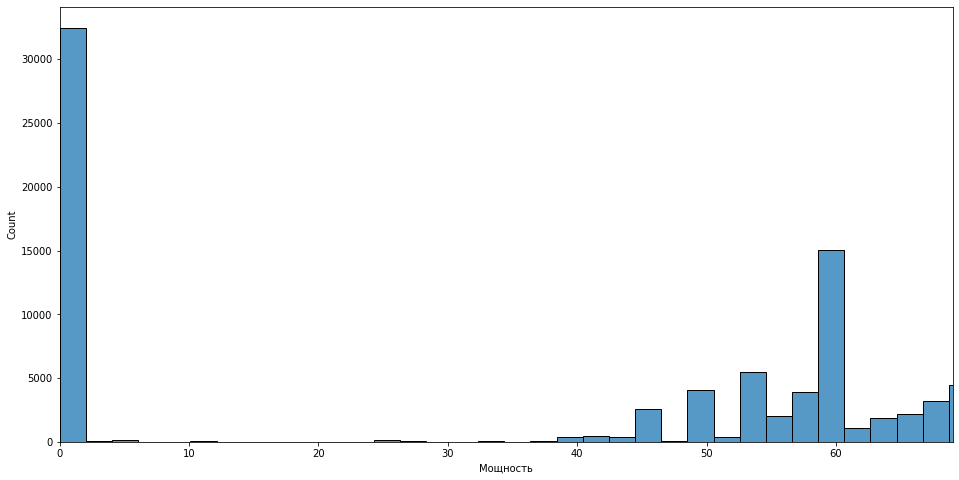

In [20]:
plt.figure(figsize=(16,8))
plt.xlabel("Мощность")
plt.xlim(0,69)
ax = sns.histplot(data["Power"])
plt.show()

Нижную границу возьмем 65, дальше все стабильно.

In [21]:
data = data.query('Power > 65 and Power < 2500')

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


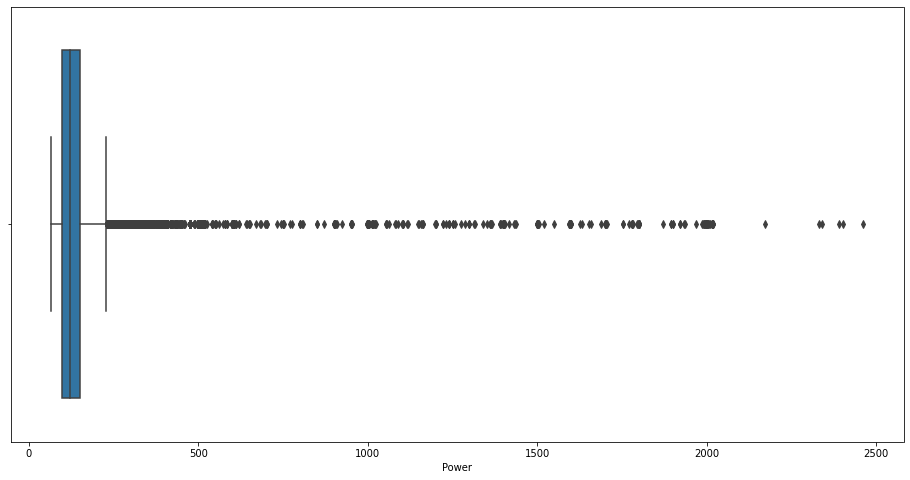

In [22]:
plt.figure(figsize=(16,8))
plt.xlabel("Количество")
ax = sns.boxplot(data["Power"])
plt.show()

Данные свыше 500 лошадиных сил тоже лучше исключить за их неоднородность и некоторую сверхъестественность.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


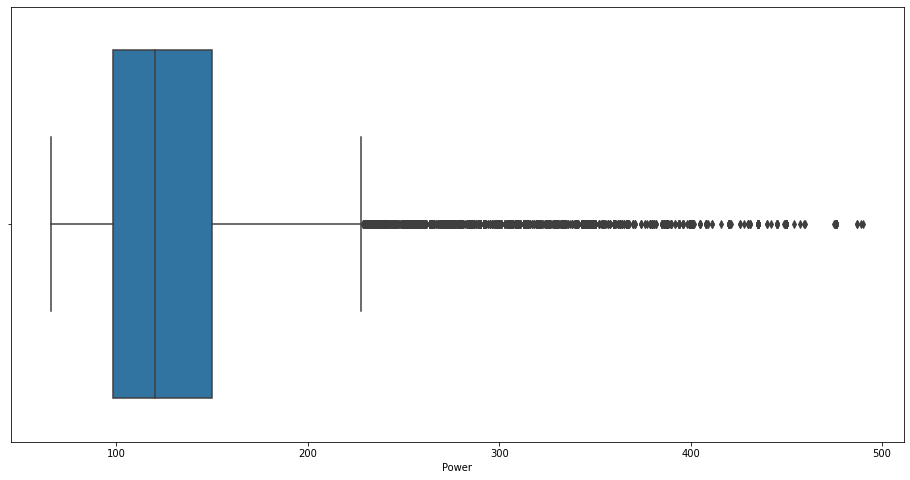

In [23]:
data = data.query(' Power < 500')
plt.figure(figsize=(16,8))
plt.xlabel("Количество")
ax = sns.boxplot(data["Power"])
plt.show()

Такая картина вполне реалисчитчна.

In [24]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,258821.000000,258821.000000,258821.000000,258821.000000,258821.000000,258821.0,258821.000000
mean,5340.614811,2004.021903,130.862921,129092.828634,6.027815,0.0,51633.768717
std,4673.888532,6.064474,49.817210,36398.072271,3.576096,0.0,25872.325198
min,169.000000,1986.000000,66.000000,5000.000000,0.000000,0.0,1067.000000
25%,1699.000000,2000.000000,98.000000,125000.000000,3.000000,0.0,31162.000000
50%,3800.000000,2004.000000,120.000000,150000.000000,6.000000,0.0,50858.000000
75%,7750.000000,2008.000000,150.000000,150000.000000,9.000000,0.0,72510.000000
max,20000.000000,2019.000000,490.000000,150000.000000,12.000000,0.0,99998.000000


Теперь значения числовых признаков выглядят выполне реалистично. Приступим к удалению ненужных столбцов, так же исправим формат записи их имен.

In [25]:
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower() for col in data.columns]
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [26]:
data = data.drop(['date_crawled', 'date_created', 'postal_code', 'last_seen', 'number_of_pictures'], axis = 1)

In [27]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes


NaN заменим на un.

In [28]:
data['gearbox'] = data['gearbox'].fillna('un')
data['vehicle_type'] = data['vehicle_type'].fillna('un')
data['fuel_type'] = data['fuel_type'].fillna('un')
data['model'] = data['model'].fillna('un')
data['repaired'] = data['repaired'].fillna('un')

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258821 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               258821 non-null  int64 
 1   vehicle_type        258821 non-null  object
 2   registration_year   258821 non-null  int64 
 3   gearbox             258821 non-null  object
 4   power               258821 non-null  int64 
 5   model               258821 non-null  object
 6   kilometer           258821 non-null  int64 
 7   registration_month  258821 non-null  int64 
 8   fuel_type           258821 non-null  object
 9   brand               258821 non-null  object
 10  repaired            258821 non-null  object
dtypes: int64(5), object(6)
memory usage: 23.7+ MB


In [30]:
data.corr()

,price,registration_year,power,kilometer,registration_month
price,1.000000,0.528195,0.453457,-0.422947,0.067366
registration_year,0.528195,1.000000,0.043655,-0.375080,0.015479
power,0.453457,0.043655,1.000000,0.110917,0.036128
kilometer,-0.422947,-0.375080,0.110917,1.000000,-0.018481
registration_month,0.067366,0.015479,0.036128,-0.018481,1.000000


Потеряли много данных, но матрица корреляций подтверждает, что востановить 0е значения через закономерность  маловероятно.

Приступим к формированию данных для обучения.
Для начала преобразуем категориальные признаки с помощью OrdinalEncoder.

In [31]:
categ_columns = data.select_dtypes(include='object').columns
data[categ_columns] = data[categ_columns].astype('category')
data_train, data_valid = train_test_split(
    data, test_size=0.4, random_state=12345)
data_test, data_valid = train_test_split(
    data_valid, test_size=0.5, random_state=12345)
enc = OrdinalEncoder()
enc.fit(data[categ_columns])
data_train[categ_columns] = enc.transform(data_train[categ_columns])
data_test[categ_columns] = enc.transform(data_test[categ_columns])
data_valid[categ_columns] = enc.transform(data_valid[categ_columns])
data.info()

/tmp/ipykernel_344/2917803440.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train[categ_columns] = enc.transform(data_train[categ_columns])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 258821 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   price               258821 non-null  int64   
 1   vehicle_type        258821 non-null  category
 2   registration_year   258821 non-null  int64   
 3   gearbox             258821 non-null  category
 4   power               258821 non-null  int64   
 5   model               258821 non-null  category
 6   kilometer           258821 non-null  int64   
 7   registration_month  258821 non-null  int64   
 8   fuel_type           258821 non-null  category
 9   brand               258821 non-null  category
 10  repaired            258821 non-null  category
dtypes: category(6), int64(5)
memory usage: 13.6 MB


In [32]:
def split_target(data):
    features = data.drop(['price'], axis=1)
    target = data['price']
    return features,target

In [33]:
features_train,target_train = split_target(data_train)
features_test,target_test = split_target(data_test)
features_valid,target_valid = split_target(data_valid)

In [34]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155292 entries, 161666 to 297758
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               155292 non-null  int64  
 1   vehicle_type        155292 non-null  float64
 2   registration_year   155292 non-null  int64  
 3   gearbox             155292 non-null  float64
 4   power               155292 non-null  int64  
 5   model               155292 non-null  float64
 6   kilometer           155292 non-null  int64  
 7   registration_month  155292 non-null  int64  
 8   fuel_type           155292 non-null  float64
 9   brand               155292 non-null  float64
 10  repaired            155292 non-null  float64
dtypes: float64(6), int64(5)
memory usage: 14.2 MB


In [35]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51764 entries, 321817 to 77540
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               51764 non-null  int64  
 1   vehicle_type        51764 non-null  float64
 2   registration_year   51764 non-null  int64  
 3   gearbox             51764 non-null  float64
 4   power               51764 non-null  int64  
 5   model               51764 non-null  float64
 6   kilometer           51764 non-null  int64  
 7   registration_month  51764 non-null  int64  
 8   fuel_type           51764 non-null  float64
 9   brand               51764 non-null  float64
 10  repaired            51764 non-null  float64
dtypes: float64(6), int64(5)
memory usage: 4.7 MB


In [36]:
data_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51765 entries, 279250 to 178703
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               51765 non-null  int64  
 1   vehicle_type        51765 non-null  float64
 2   registration_year   51765 non-null  int64  
 3   gearbox             51765 non-null  float64
 4   power               51765 non-null  int64  
 5   model               51765 non-null  float64
 6   kilometer           51765 non-null  int64  
 7   registration_month  51765 non-null  int64  
 8   fuel_type           51765 non-null  float64
 9   brand               51765 non-null  float64
 10  repaired            51765 non-null  float64
dtypes: float64(6), int64(5)
memory usage: 4.7 MB


Удалим все ненужное

In [37]:
del data, categ_columns,enc,data_train,data_test,data_valid

**Подведем итоги подготовки данных:**
Данные поступили низкого качества и пришлось проделать достаточно работы, что бы привести их в подобающее состояние:
* В столбцах категориальных признаков NaN заменили на un, то есть добавили новые категории
* Привели названия столбцов к подходящему для работы формату
* Убрали выбросы в численных признаках, так же избавились от 0 значений в них же, заменить эти значения( скорее всего пропуски в данных) не представлялось возможным в данных условиях

Для нахождения выбросов были применены графические методы (boxplot, countplot, histplot)


## Обучение моделей

Для рассмотрения моделей напишем функцию вывода результатов

In [38]:
def model_result_(model, features_train, features_test, target_train, target_test):
    start1 = time.time()
    model.fit(features_train, target_train)
    end1 = time.time()
    time_train = end1 - start1

    start2 = time.time()
    pred = model.predict(features_test)
    end2 = time.time()
    time_predict = end2 - start2

    rmse = mean_squared_error(target_test, pred) ** 0.5
    return [round(rmse), round(time_train, 1), round(time_predict, 1)]
random_state = 12345

In [39]:
best_rmse = 60000
for est in  [60,80]: 
    for dep in [5,10]:
        lgb_model = LGBMRegressor(random_state=random_state, max_depth=dep, n_estimators=est,)
        start1 = time.time()
        lgb_model.fit(features_train, target_train)
        end1 = time.time()
        time_train = end1 - start1
        print(time_train)
        start2 = time.time()
        pred = lgb_model.predict(features_test)
        end2 = time.time()
        time_predict = end2 - start2
        rmse = mean_squared_error(target_test, pred) ** 0.5
        if rmse < best_rmse:
            best_rmse = rmse
            result = [time_train,time_predict] 
            best_depth = dep
            best_estimators = est
print("RMSE:",best_rmse, "time_train:",result[0],"time_predict",result[1],"глубина:", best_depth, "количество деревьев:" ,best_estimators)


271.8379137516022
176.87088918685913
312.0621030330658
468.0672559738159
RMSE: 1788.5888850227088 time_train: 468.0672559738159 time_predict 0.42269182205200195 глубина: 10 количество деревьев: 80


In [40]:
results = pd.DataFrame(columns = ['model', 'rmse', 'time_train', 'time_predict'])
results = results.append({'model': 'RandomForestRegressor', 'rmse': best_rmse,
                    'time_train': result[0], 'time_predict': result[1]}, ignore_index=True)

In [41]:
best_rmse = 60000
for est in [20,30,40,50]: 
    for dep in [5,10]:
        rfr_model = RandomForestRegressor(random_state=random_state, max_depth=dep, n_estimators=est)
        start1 = time.time()
        rfr_model.fit(features_train, target_train)
        end1 = time.time()
        time_train = end1 - start1
        start2 = time.time()
        pred = rfr_model.predict(features_test)
        end2 = time.time()
        time_predict = end2 - start2
        rmse = mean_squared_error(target_test, pred) ** 0.5
        if rmse < best_rmse:
            best_rmse = rmse
            result = [time_train,time_predict] 
            best_depth = dep
            best_estimators = est
print("RMSE:",best_rmse, "time_train:",result[0],"time_predict",result[1],"глубина:", best_depth, "количество деревьев:" ,best_estimators)
results = results.append({'model': 'LGBMRegressor', 'rmse': best_rmse,
                    'time_train': result[0], 'time_predict': result[1]}, ignore_index=True)

RMSE: 1936.5867642222304 time_train: 8.3895742893219 time_predict 0.18004369735717773 глубина: 10 количество деревьев: 40


## Анализ моделей

Посмотрим на результаты отобранных моделей и сравним.

In [42]:
results

,model,rmse,time_train,time_predict
0,RandomForestRegressor,1788.588885,468.067256,0.422692
1,LGBMRegressor,1936.586764,8.389574,0.180044


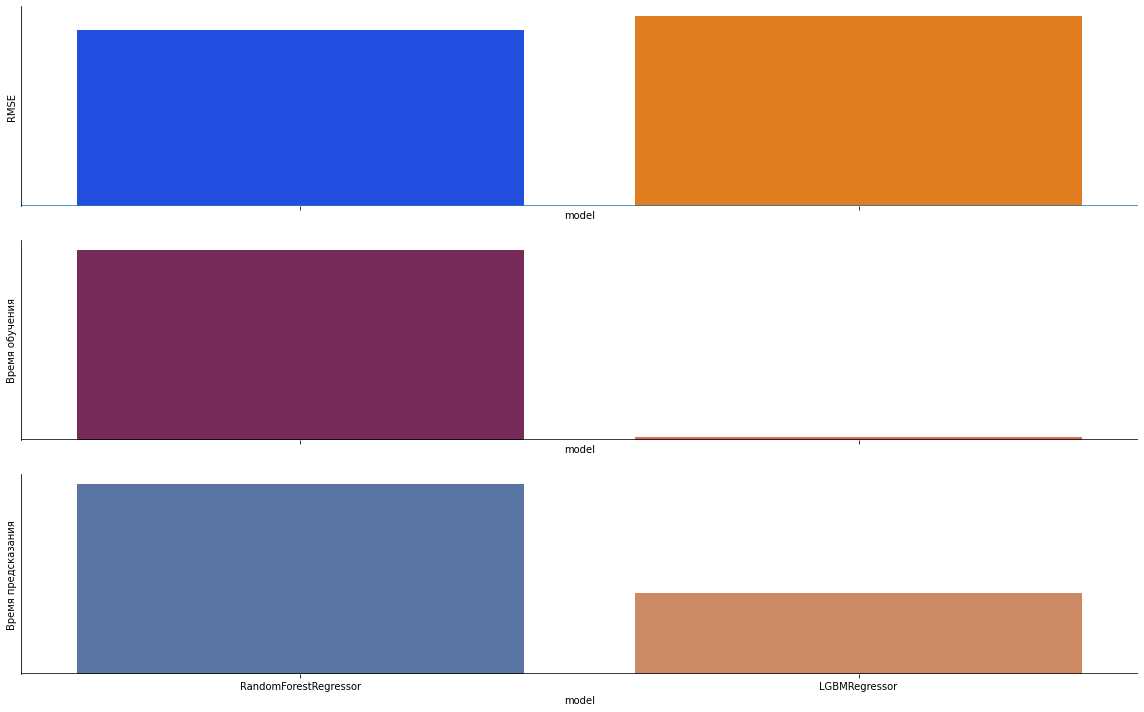

In [45]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

x = results['model']
y1 = results['rmse']
sns.barplot(x=x, y=y1, palette="bright", ax=ax1)
ax1.axhline(0,)
ax1.set_ylabel("RMSE")

y2 = results['time_train']
sns.barplot(x=x, y=y2, palette="rocket", ax=ax2)
ax2.axhline(0, color="k")
ax2.set_ylabel("Время обучения")

y3 = results['time_predict']
sns.barplot(x=x, y=y3, palette="deep", ax=ax3)
ax3.axhline(0, color="k")
ax3.set_ylabel("Время предсказания")

sns.despine(bottom=True)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

**Вывод:**
Обе модели дают досаточно точные ответы, время обучения LGBMRegressor, конечно оставляет желать лучшего, но это скорее скажется на работе разработчика, т.к. предсказывает она так же быстро.

К работе заказчику я бы рекомендовал модель случайного леса, т.к. ее проще переобучить, и результат точнее, скорость предскказания настолько высока у обеих моделей, что этот фактор из сравнения можно убрать.

Посмотрим на результаты рекомендованной нами модели на валидационной(да да тестовой) выборке.

In [48]:
start2 = time.time()
pred = rfr_model.predict(features_valid)
end2 = time.time()
time_predict = end2 - start2
rmse = mean_squared_error(target_valid, pred) ** 0.5
print ("RMSE:",rmse, "time_predict:",time_predict)

RMSE: 1922.7794624384396 time_predict: 0.2449812889099121




**Вывод по проделанной работе:**
Полученные данные были достаточно грязными, и не малую часть работы заняло преведение их в стоящий вид, дольшинство характеристик категориальные, что по этому было решено преобразовать их с помощью OrdinalEncoder. Подбор гиперпараметров оказался досаточно длительным из-за долгого времени обучения LGBMRegressor, скорее всего можно было облегчить данные.
(*Ohe просто убивал работу) В результате было получено две модели с характеристиками удовлетворяющими условю заказа RMSE<2500.

В итоге было принято решение работать с моделью случайного леса, т.к. ее RMSE  ниже. 

**Небольшое предположение** 
Вызов функции получения результата как будто еще сильнее замедляет работу тетрадки.